# Notebook 04 – Distributed Models  
*This notebook trains and interprets distributed models that predict persuasive success based on post-level features from CMV.*

> **Goal in one line:** build scalable, interpretable models to predict whether a post convinces the original author, while addressing class imbalance and evaluating feature relevance.



Our aim is to understand the relationship between linguistic, structural, and stylistic features of Reddit posts and the likelihood of persuasion (i.e., receiving a Δ). We prioritize interpretability and scalability by using decision trees and distributed training.

This notebook includes:
- Baseline decision tr and Random Forestees with and without class rebalancing  
- Feature importance scores and their interpretability  
- A logistic regression model to assess directionality  
- Partial dependence plots to visualize non-linear effects  
- A distributed bagging approach using partition-level parallelism

We intentionally omit more complex black-box models due to the moderate dataset size and the low-dimensional feature space. This trade-off is discussed in more depth in the report.


 

### Import statements

In [7]:
# Standard library imports
import re
import string
from datetime import datetime
import hashlib

# Data processing and numerical computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# NLP and text processing
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# PySpark core
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, 
    ArrayType, BooleanType, FloatType
)
import pyspark.sql.functions as sql_f
from pyspark.sql.functions import (
    col, lit, when, regexp_replace
)

# PySpark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    HashingTF, IDF, Tokenizer, VectorAssembler, 
    StopWordsRemover, OneHotEncoder, StringIndexer
)
from pyspark.ml.classification import (
    DecisionTreeClassifier, RandomForestClassifier
)
import pyspark.ml.classification as cl
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator, 
    MulticlassClassificationEvaluator
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Scikit-learn
from sklearn.metrics import (
    classification_report, recall_score, f1_score, 
    precision_score, accuracy_score, confusion_matrix
)
from sklearn.tree import export_text, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import time

## 1 – Data preprocessing

In [3]:
# Description of new fields only, for previous
schema_four = StructType([
    StructField("num_comments", IntegerType(), True),    # Number of comments on the post
    StructField("score", IntegerType(), True),           # Reddit score (upvotes - downvotes)
    StructField("delta", BooleanType(), True),           # Whether the post received a delta (changed view)
    StructField("urls", ArrayType(StringType()), True),  # URLs mentioned in the post
    StructField("processed", ArrayType(StringType()), True),  # Preprocessed tokens
    StructField("merged", StringType(), True),           # Merged text field (likely title + selftext)
    StructField("year_month", StringType(), True),        # Time period for temporal analysis
    StructField("category_title",StringType(),True),     # Interpretable category title
    StructField("title", StringType(), True),            # Title of the post
    StructField("selftext", StringType(), True),         # Body text of the post
    StructField("first_person_singular_count", IntegerType(), True),  # Count of "I", "me", "my", "mine" in the post
    StructField("first_person_plural_count", IntegerType(), True),    # Count of "we", "us", "our", "ours" in the post
    StructField("post_content_length", IntegerType(), True),          # Number of tokens in the main body (selftext)
    StructField("title_content_length", IntegerType(), True),         # Number of tokens in the title
    StructField("has_url", IntegerType(), True),                      # 1 if post contains at least one URL, 0 otherwise
    StructField("fk_grade", StringType(), True),                      # Flesch–Kincaid readability grade (as string to allow nulls)
    StructField("sentiment", FloatType(), True),                      # VADER compound sentiment score (-1 = neg, +1 = pos)
])


# Read and Display preprocessed data from Bucket 
n4_categorized = spark.read.schema(schema_four).json("gs://st446-cmv/n3_features_df")
n4_categorized = n4_categorized.withColumn("delta", col("delta").cast("int"))
n4_categorized = n4_categorized.withColumn("fk_grade", col("fk_grade").cast("float"))
n4_categorized.show(5)

25/05/06 09:46:22 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/06 09:46:37 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/06 09:46:52 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/06 09:47:07 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/06 09:47:22 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/06 09:47:37 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registere

+------------+-----+-----+-----------+---------+--------------------+----------+--------------+--------------------+--------------------+---------------------------+-------------------------+-------------------+--------------------+-------+--------+---------+
|num_comments|score|delta|       urls|processed|              merged|year_month|category_title|               title|            selftext|first_person_singular_count|first_person_plural_count|post_content_length|title_content_length|has_url|fk_grade|sentiment|
+------------+-----+-----+-----------+---------+--------------------+----------+--------------+--------------------+--------------------+---------------------------+-------------------------+-------------------+--------------------+-------+--------+---------+
|           1|    1|    0|         []|     NULL| I believe that A...|   2013-07|       Culture|I believe that Ap...|                    |                          1|                        0|                  1|         

In [4]:
# Display label distribution
n4_categorized.groupBy("delta").count().show()

+-----+-----+
|delta|count|
+-----+-----+
|    1| 9208|
|    0|55961|
+-----+-----+



###  Class Imbalance Warning

A key limitation of our dataset is the strong **class imbalance** between persuasive and non-persuasive posts. As shown in the table below, only about **14%** of posts receive a delta.

| `delta` | Count |
|--------:|------:|
| 1       | 9,208 |
| 0       | 55,961 |

This corresponds to roughly a **1:6 ratio** of positive (persuasion) to negative (no persuasion) cases.

While this is sufficient to train models, class imbalance may:
- Bias metrics like accuracy
- Increase false negatives
- Require balancing techniques (reweighting, sampling)

We account for this in both our model selection and evaluation.


### Basic Feature Preprocessing

In [5]:
# Converting categorical text values to numerical indices
label_indexer = StringIndexer(inputCol="category_title", outputCol="category_index")
n4_categorized = label_indexer.fit(n4_categorized).transform(n4_categorized)

cols = n4_categorized.columns
new_col_order = [c for c in cols if c != "delta"] + ["delta"]
n4_categorized = n4_categorized.select(*new_col_order)

# Removing columns that aren't needed for modeling
n4_dropped = n4_categorized.drop("urls").drop("merged").drop("year_month").drop("title").drop("selftext").drop("processed").drop("category_title")

# Converting to Pandas for scikit-learn modeling
results = n4_dropped.toPandas()
results['category_index'] = results['category_index'].astype('category')

In [6]:
results

,num_comments,score,first_person_singular_count,first_person_plural_count,post_content_length,title_content_length,has_url,fk_grade,sentiment,category_index,delta
0,1,1,1,0,1,12,0,8.380000,0.5423,5.0,0
1,2,2,8,1,100,13,1,5.570000,-0.3618,0.0,0
2,44,22,5,1,117,20,0,10.810000,-0.1796,3.0,0
3,30,22,1,1,94,20,0,10.060000,-0.8301,1.0,0
4,36,0,35,19,758,14,0,7.920000,0.9980,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
65164,72,83,22,4,412,18,0,8.200000,0.4636,0.0,0
65165,49,0,15,0,769,28,0,16.950001,0.9957,0.0,0
65166,122,29,32,5,873,9,0,9.090000,0.7125,2.0,0
65167,6,1,0,1,1,15,0,7.570000,0.0000,0.0,0


## 2 – Classification models for Δ
-----------------------------------------------------------------------------
At this point, we've prepared our data for classification modeling. We'll now:
  1. Split our data into training and testing sets
  2. Train two models:
     - Decision Tree: A simpler model that creates a flowchart-like structure of decisions
     - Random Forest: An ensemble of many decision trees that typically offers better performance
  3. Compare their performance using classification metrics

Both models will be configured to handle our class imbalance problem (we have many more 
non-delta comments than delta comments). We'll use max_depth=10 for both models to ensure
they can capture the patterns in the minority class without overfitting too severely.

In [8]:
# Creating dummy variables by one-hot encoding for categorical variables
category_dummies = pd.get_dummies(results['category_index'], prefix='category', drop_first=True)
encoded = pd.concat([results.drop('category_index', axis=1), category_dummies.astype('int')], axis=1)

# Creating a version without categories as another option
no_cats = results.drop(columns='category_index')

# Iteration 1 does *not* consider Categories
df = no_cats 

# Separating features and target variable
X = df.drop(columns=["delta"])
y = df["delta"]

# Random 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5
)

#  MODEL TRAINING 

# A. Decision Tree classifier with max_depth to control complexity
start_dt = time.time() # Measuring run time 
dt_clf = DecisionTreeClassifier(random_state=2, max_depth=10)

dt_clf.fit(X_train.values, y_train.values)

end_dt = time.time() # Measuring Run Time

dt_predictions = dt_clf.predict(X_test.values)


# B. Random Forest classifier with 500 trees and similar max_depth as DT
start_rf = time.time()
rf_clf = RandomForestClassifier(n_estimators=500,         # Number of trees in the forest
                              max_depth=10,             # Same max depth as decision tree for comparison
                              max_features=.8,          # Using 80% of features for each split consideration
                              random_state=2)           

rf_clf.fit(X_train.values, y_train.values)
end_rf = time.time()
rf_predictions = rf_clf.predict(X_test.values)

#  MODEL EVALUATION

print("Decision Tree Results:")
print(classification_report(y_test.values, dt_predictions, target_names=["No delta", "delta"]))
cm = confusion_matrix(y_test, dt_predictions)
cm_dt = pd.DataFrame(
    cm,
    index=["Actual: No delta", "Actual: Delta"],
    columns=["Predicted: No delta", "Predicted: Delta"]
)
print("\nConfusion Matrix:")
print(cm_dt)
print(f"\nDecision Tree training time: {end_dt - start_dt:.4f} seconds")
print("\n----------------------------------")

print("\nRandom Forest Results:")
print(classification_report(y_test.values, rf_predictions, target_names=["No delta", "delta"]))
cm = confusion_matrix(y_test, rf_predictions)
cm_rf = pd.DataFrame(
    cm,
    index=["Actual: No delta", "Actual: Delta"],
    columns=["Predicted: No delta", "Predicted: Delta"]
)
print("\nConfusion Matrix:")
print(cm_rf)
print(f"\nRandom Forest training time: {end_rf - start_rf:.4f} seconds")



#We had to put a max depth of 10 otherwise our model would predict everything as 0 (non delta) due to the class
#imbalance. By increasing the depth of our tree, we risk overfitting but we also could catch subtle patterns. 

Decision Tree Results:
              precision    recall  f1-score   support

    No delta       0.86      0.99      0.92     16765
       delta       0.22      0.02      0.04      2786

    accuracy                           0.85     19551
   macro avg       0.54      0.50      0.48     19551
weighted avg       0.77      0.85      0.79     19551


Confusion Matrix:
                  Predicted: No delta  Predicted: Delta
Actual: No delta                16560               205
Actual: Delta                    2728                58

Decision Tree training time: 0.1692 seconds

----------------------------------

Random Forest Results:
              precision    recall  f1-score   support

    No delta       0.86      1.00      0.92     16765
       delta       0.39      0.01      0.01      2786

    accuracy                           0.86     19551
   macro avg       0.62      0.50      0.47     19551
weighted avg       0.79      0.86      0.79     19551


Confusion Matrix:
            

**Takeaway**

As an initial analysis, Random Forest performs better than Decision Trees in predicting 'delta' without significantly compromising the accuracy of 'no-delta' predictions.

Next, we aim to fit both classifiers on the dataframe that includes the categorical index.

In [9]:
# Creating dummy variables by one-hot encoding for categorical variables
category_dummies = pd.get_dummies(results['category_index'], prefix='category', drop_first=True)
encoded = pd.concat([results.drop('category_index', axis=1), category_dummies.astype('int')], axis=1)

# Creating a version without categories as another option
no_cats = results.drop(columns='category_index')

# Iteration 2 considers Categories
df = encoded 

# Separating features and target variable
X = df.drop(columns=["delta"])
y = df["delta"]

# Random 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5
)

#  MODEL TRAINING 

# A. Decision Tree classifier with max_depth to control complexity
dt_start = time.time()
dt_clf = DecisionTreeClassifier(random_state=2, max_depth=10)

dt_clf.fit(X_train.values, y_train.values)
dt_end = time.time()
dt_predictions = dt_clf.predict(X_test.values)


# B. Random Forest classifier with 500 trees and similar max_depth as DT
rf_start = time.time()
rf_clf = RandomForestClassifier(n_estimators=500,         # Number of trees in the forest
                              max_depth=10,             # Same max depth as decision tree for comparison
                              max_features=.8,          # Using 80% of features for each split consideration
                              random_state=2)           

rf_clf.fit(X_train.values, y_train.values)
rf_end = time.time() 
rf_predictions = rf_clf.predict(X_test.values)
rf_with_category = rf_predictions # For later use

#  MODEL EVALUATION

print("Decision Tree Results:")
print(classification_report(y_test.values, dt_predictions, target_names=["No delta", "delta"]))
cm = confusion_matrix(y_test, dt_predictions)
cm_dt = pd.DataFrame(
    cm,
    index=["Actual: No delta", "Actual: Delta"],
    columns=["Predicted: No delta", "Predicted: Delta"]
)
print("\nConfusion Matrix:")
print(cm_dt)
print(f"\nDecision Tree training time: {dt_end - dt_start:.4f} seconds")


print("\n----------------------------------")

print("\nRandom Forest Results:")
print(classification_report(y_test.values, rf_predictions, target_names=["No delta", "delta"]))
cm = confusion_matrix(y_test, rf_predictions)
cm_rf = pd.DataFrame(
    cm,
    index=["Actual: No delta", "Actual: Delta"],
    columns=["Predicted: No delta", "Predicted: Delta"]
)
print("\nConfusion Matrix:")
print(cm_rf)
print(f"\nRandom Forest training time: {rf_end - rf_start:.4f} seconds")

Decision Tree Results:
              precision    recall  f1-score   support

    No delta       0.86      0.99      0.92     16765
       delta       0.27      0.02      0.04      2786

    accuracy                           0.85     19551
   macro avg       0.56      0.51      0.48     19551
weighted avg       0.77      0.85      0.79     19551


Confusion Matrix:
                  Predicted: No delta  Predicted: Delta
Actual: No delta                16578               187
Actual: Delta                    2718                68

Decision Tree training time: 0.1989 seconds

----------------------------------

Random Forest Results:
              precision    recall  f1-score   support

    No delta       0.86      1.00      0.92     16765
       delta       0.43      0.01      0.01      2786

    accuracy                           0.86     19551
   macro avg       0.65      0.50      0.47     19551
weighted avg       0.80      0.86      0.79     19551


Confusion Matrix:
            

In [10]:
#further checks given the class imbalance. The class balance is reasonable in each test and training set. 
print(y_train.value_counts())
print(y_test.value_counts())


delta
0    39196
1     6422
Name: count, dtype: int64
delta
0    16765
1     2786
Name: count, dtype: int64


### 2.1 - Visualize the decision tree structure to understand its decision boundaries

This helps interpret what features the model considers most important:

First four splits come from [0] = 'num_comments' and the fifth one is [5] = title_content_length

[Text(0.4111377529510961, 0.9545454545454546, 'x[0] <= 14.5\ngini = 0.242\nsamples = 45618\nvalue = [39196, 6422]'),
 Text(0.16854184232715008, 0.8636363636363636, 'x[0] <= 7.5\ngini = 0.058\nsamples = 16051\nvalue = [15567, 484]'),
 Text(0.06302698145025296, 0.7727272727272727, 'x[0] <= 3.5\ngini = 0.014\nsamples = 11176\nvalue = [11098, 78]'),
 Text(0.021922428330522766, 0.6818181818181818, 'x[0] <= 2.5\ngini = 0.002\nsamples = 8580\nvalue = [8572, 8]'),
 Text(0.00927487352445194, 0.5909090909090909, 'x[5] <= 3.5\ngini = 0.001\nsamples = 7906\nvalue = [7903, 3]'),
 Text(0.00505902192242833, 0.5, 'x[0] <= 0.5\ngini = 0.017\nsamples = 118\nvalue = [117, 1]'),
 Text(0.003372681281618887, 0.4090909090909091, 'x[10] <= 0.5\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.0016863406408094434, 0.3181818181818182, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.00505902192242833, 0.3181818181818182, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.006745362563237774, 0.4090909090

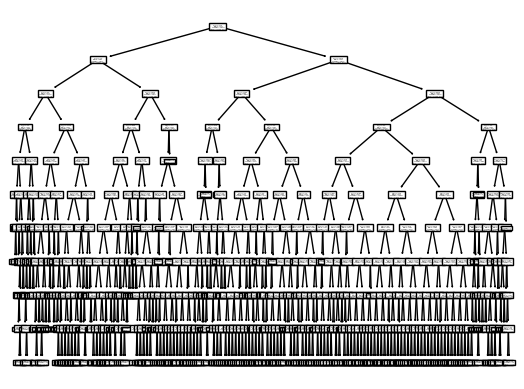

In [11]:
# Visualize the decision tree structure to understand its decision boundaries

from sklearn import tree
tree.plot_tree(dt_clf)


### 2.2 - Metrics analysis

The accuracy is as expected high even with a simple shallow tree because of the imbalance in the data. Our model 
has most likely learned that it will often be right if it classifies as no delta. 
we'd expect our recall to be low in contrast.

In [12]:
predictions = dt_clf.predict(X_test.values)
accuracy = accuracy_score(y_test.values, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.8514142499104905


In [13]:
print("Recall:", recall_score(y_test.values, predictions))
print("F1 Score:", f1_score(y_test.values, predictions))
print("Precision:", precision_score(y_test.values, predictions))

Recall: 0.024407753050969132
F1 Score: 0.04472213087800066
Precision: 0.26666666666666666


### 2.3 - Account for class balance

Given the poor metrics of our model, we made a second simple decision tree 
baseline model with which we could compare our distributed approach. 

In [14]:
# Creating dummy variables by one-hot encoding for categorical variables
category_dummies = pd.get_dummies(results['category_index'], prefix='category', drop_first=True)
encoded = pd.concat([results.drop('category_index', axis=1), category_dummies.astype('int')], axis=1)
no_cats = results.drop(columns='category_index')


# Iteration 3 *considers Categories and performs balancing on Class weights*.
df = encoded 

# Separating features and target variable
X = df.drop(columns=["delta"])
y = df["delta"]

# Random 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5
)

#  MODEL TRAINING 

# A. Decision Tree classifier with max_depth to control complexity
dt_start_one = time.time()
dt_clf = DecisionTreeClassifier(random_state=2, 
                             max_depth=10, 
                             class_weight='balanced')

dt_clf.fit(X_train.values, y_train.values)
dt_end_one = time.time()
dt_predictions = dt_clf.predict(X_test.values)



# B. Random Forest classifier with 500 trees and similar max_depth as DT
rf_start_one = time.time()
rf_clf = RandomForestClassifier(n_estimators=500,         # Number of trees in the forest
                                max_depth=10,             # Same max depth as decision tree for comparison
                                max_features=.8,          # Proportion of features considered for each tree
                                random_state=2,           
                                class_weight='balanced')  
                            
rf_clf.fit(X_train.values, y_train.values)
rf_end_one = time.time()
rf_predictions = rf_clf.predict(X_test.values)



#  MODEL EVALUATION

print("Decision Tree Results with weighted class:")
print(classification_report(y_test.values, dt_predictions, target_names=["No delta", "delta"]))
cm = confusion_matrix(y_test, dt_predictions)
cm_dt = pd.DataFrame(
    cm,
    index=["Actual: No delta", "Actual: Delta"],
    columns=["Predicted: No delta", "Predicted: Delta"]
)
print("\nConfusion Matrix:")
print(cm_dt)
print(f"\nDecision Tree training time: {dt_end_one - dt_start_one:.4f} seconds")


print("\n----------------------------------")

print("\nRandom Forest Results with weighted class:")
print(classification_report(y_test.values, rf_predictions, target_names=["No delta", "delta"]))
cm = confusion_matrix(y_test, rf_predictions)
cm_rf = pd.DataFrame(
    cm,
    index=["Actual: No delta", "Actual: Delta"],
    columns=["Predicted: No delta", "Predicted: Delta"]
)
print("\nConfusion Matrix:")
print(cm_rf)
print(f"\nRandom Forest training time: {rf_end_one - rf_start_one:.4f} seconds")

Decision Tree Results with weighted class:
              precision    recall  f1-score   support

    No delta       0.94      0.56      0.70     16765
       delta       0.23      0.79      0.35      2786

    accuracy                           0.59     19551
   macro avg       0.58      0.67      0.53     19551
weighted avg       0.84      0.59      0.65     19551


Confusion Matrix:
                  Predicted: No delta  Predicted: Delta
Actual: No delta                 9308              7457
Actual: Delta                     598              2188

Decision Tree training time: 0.2039 seconds

----------------------------------

Random Forest Results with weighted class:
              precision    recall  f1-score   support

    No delta       0.94      0.59      0.73     16765
       delta       0.24      0.76      0.36      2786

    accuracy                           0.62     19551
   macro avg       0.59      0.68      0.54     19551
weighted avg       0.84      0.62      0.67   

### 2. 5 - Best model confusion matrix

## 3 - Feature Importance & Direction

We want to understand which features most influence our classification decisions, not just how well the model performs. Tree-based models like Decision Trees and Random Forests provide built-in feature importance scores that help interpret which features contribute most to the model's decision-making.

This is critical for us, since our research goal prioritizes interpretability over pure predictive performance.

We first extract and examine the feature importance from a Decision Tree, and then from a Random Forest. These scores reflect how often and how effectively each feature is used to split the data across the tree(s).

-----------------------------------------------------------------------------
Note: These scores tell us **how important a feature is, but not the direction of its effect** (i.e., whether an increase in the feature is positively or negatively correlated with the target). For that, **we will later use a simple logistic regression**.

### 3.1 - Feature Importance for both models

In [15]:
# Extract feature importances from both models
dt_importances = dt_clf.feature_importances_
rf_importances = rf_clf.feature_importances_

# Create DataFrames for easier analysis with feature names
feature_names = X.columns
dt_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_importances
}).sort_values('importance', ascending=False)

rf_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

# Display top 10 features for each model
print("\nDecision Tree - Top 8 Feature Importances:")
print(dt_importance_df.head(8))

print("\nRandom Forest - Top 8 Feature Importances:")
print(rf_importance_df.head(8))



Decision Tree - Top 8 Feature Importances:
                       feature  importance
0                 num_comments    0.592472
4          post_content_length    0.146461
7                     fk_grade    0.056967
8                    sentiment    0.047938
1                        score    0.043568
5         title_content_length    0.038383
2  first_person_singular_count    0.027537
3    first_person_plural_count    0.022442

Random Forest - Top 8 Feature Importances:
                       feature  importance
0                 num_comments    0.491829
4          post_content_length    0.196553
7                     fk_grade    0.065024
8                    sentiment    0.058142
1                        score    0.057945
5         title_content_length    0.049223
2  first_person_singular_count    0.041590
3    first_person_plural_count    0.015729


### 3.2 Direction

In [16]:
#Interpretable simple logistic regression (non parallelized) using same as above model.
from sklearn.linear_model import LogisticRegression
feature_columns = ["num_comments", "first_person_singular_count", "first_person_plural_count", "post_content_length", "title_content_length","fk_grade","has_url","sentiment","category_index","score" ]
logit = LogisticRegression(max_iter = 1000, random_state=2, class_weight='balanced')

lg_model = logit.fit(X_train, y_train)
for feature, coef in zip(feature_columns, lg_model.coef_[0]):
    print(f"{feature}: {'+' if coef > 0 else '-'}{abs(coef):.3f}")
#Given the result we see slight linear corrleation for some of the features such as fk_grade but others aren't.

num_comments: +0.002
first_person_singular_count: +0.001
first_person_plural_count: +0.000
post_content_length: -0.011
title_content_length: +0.002
fk_grade: -0.023
has_url: +0.309
sentiment: +0.048
category_index: +0.040
score: -0.009


### First attempt at understanding direction of features

The partial dependency showcases the average predicted probability of delta = 1 when fk_grade is fixed at a given value, and all other features take their actual values in the dataset.

In this case, starting from an elementary school level, the more complex it gets, the more likely it is to obtain a Delta.

/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: 

/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


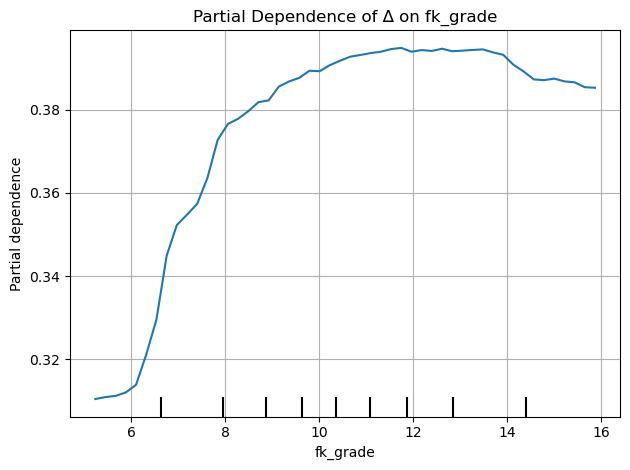

In [17]:
# Plot PDP for one feature (can also pass a list of feature indices or names)
PartialDependenceDisplay.from_estimator(
    rf_clf,                  
    X_train,                 
    features=["fk_grade"],   
    kind="average",          # average prediction over marginal distribution
    grid_resolution=50,      
)

plt.title("Partial Dependence of ∆ on fk_grade")
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: 

/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


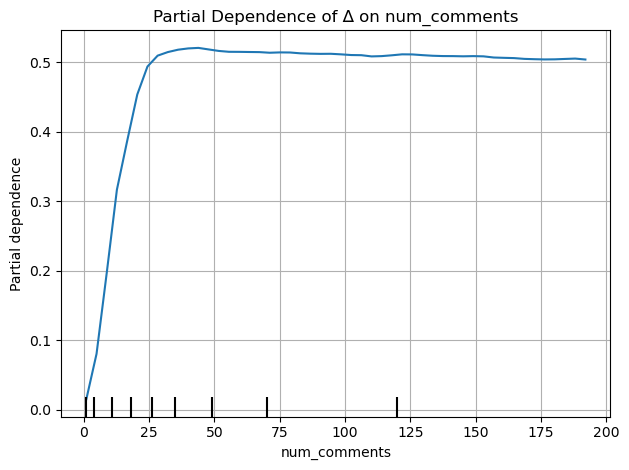

In [63]:
# Plot PDP for one feature (can also pass a list of feature indices or names)
PartialDependenceDisplay.from_estimator(
    rf_clf,                  
    X_train,                 
    features=["num_comments"],   
    kind="average",          # average prediction over marginal distribution
    grid_resolution=50,      
)

plt.title("Partial Dependence of ∆ on num_comments")
plt.grid(True)
plt.tight_layout()
plt.show()

### Takeaway from interpretable & baseline model 
We ran a baseline decision tree model. Its useful for us to understand which features have greatest improtance in predicting whether a delta was awarded and thus if the original poster (OP) was convinced. 
It turns out that in order of importance 1) Number of comments: the greater the amount of comments the more likely the OP was convinced. 2)post content length 3) Flesch Kincaid grade are the three most important features whether a person was convinced or not.  

We then ran a logistic regression which assumes linearity which we expected would capture relationships between post length. 

Write more: quite complex we see we need to go more in detail right, and that linear assumption in this case doesn't work much. People might get convinced if there's 15 posts or in between. 

Note:
We mapped out the feature number with the features for interpretation of the trees above. 
- feature 0-> num_comments
- feature 1->first_person_singular_count
- feature 2->	first_person_plural_count
- feature 3->	post_content_length
- feature 4->	title_content_length
- feature 5->	fk_grade
- feature 6->	has_url
- feature 7->	sentiment


## 4 - Distributed approach

In [52]:
# Creating dummy variables by one-hot encoding for categorical variables
category_dummies = pd.get_dummies(results['category_index'], prefix='category', drop_first=True)
encoded = pd.concat([results.drop('category_index', axis=1), category_dummies.astype('int')], axis=1)

# Creating a version without categories as another option
no_cats = results.drop(columns='category_index')

# Iteration 2 considers Categories
df_distributed = encoded 




In [53]:
df_spark = spark.createDataFrame(df_distributed)


In [54]:
# Split data into training and testing sets with a 70/30 ratio
train_df, test_df = df_spark.randomSplit([0.7, 0.3], seed=888321)
df_spark.rdd.getNumPartitions()  # Initial data was partitioned in 4


4

In [55]:
df_spark.columns

['num_comments',
 'score',
 'first_person_singular_count',
 'first_person_plural_count',
 'post_content_length',
 'title_content_length',
 'has_url',
 'fk_grade',
 'sentiment',
 'delta',
 'category_1.0',
 'category_2.0',
 'category_3.0',
 'category_4.0',
 'category_5.0',
 'category_6.0',
 'category_7.0',
 'category_8.0',
 'category_9.0',
 'category_10.0',
 'category_11.0',
 'category_12.0',
 'category_13.0']

In [56]:
# Increase the number of partitions for parallel processing
# This enables more parallelization across the cluster
train_rdd = train_df.rdd.repartition(12)  # Creating 12 partitions for training data
test_rdd = test_df.rdd.repartition(12)    # Creating 12 partitions for test data
column_names = df_spark.columns

### 4.1 - Distributed Decision Tree

The system architecture follows a "local model parallel" approach where:

1. Data is partitioned across worker nodes
2. Each partition trains an independent decision tree model
3. Predictions are aggregated through majority voting
4. Models are broadcast to worker nodes for efficient prediction

Useful link [https://github.com/lse-st446/lectures2025/blob/main/Week10/class/code/w10_DT_LocalGlobal.ipynb]

In [57]:
# Function to build a decision tree model on each partition
def build_model(partition_data_it):
    # Convert partition iterator to pandas DataFrame for scikit-learn compatibility
    partition_data_df = pd.DataFrame(partition_data_it, columns=column_names)
    
    clf = DecisionTreeClassifier(random_state=2, max_depth=10, class_weight='balanced') # balanced is optional
    

    X_train = partition_data_df.drop(columns = "delta")  
    y_train = partition_data_df["delta"]      # Target
    
    # Train the model on this partition's data
    model = clf.fit(X_train.values, y_train.values)
    
    # Return the trained model as a list (required for mapPartitions)
    return [model]

distributed_dt_model_start = time.time()
models = train_rdd.mapPartitions(build_model).collect()
distributed_dt_model_end = time.time()
print(f"\nDecision Tree training time: {distributed_dt_model_end - distributed_dt_model_start:.4f} seconds")


25/05/06 11:07:50 WARN TaskSetManager: Stage 74 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.



Decision Tree training time: 149.1582 seconds


**Prediction Process**

Models are broadcast to all worker nodes using broadcast_models
For each test instance, predictions are gathered from all models
Final prediction is determined by majority voting through the agg_predictions function

In [58]:
# Broadcast the models to all worker nodes to make them available for prediction
# This avoids sending the models repeatedly for each prediction

broadcast_models = spark.sparkContext.broadcast(models)

# Make predictions using all models
def predict(instance):
    values = list(instance.asDict().values())[:-1]
    model_list = broadcast_models.value
    return [m.predict([values])[0] for m in model_list]

# Aggregate predictions from all models (ensemble voting)
def agg_predictions(preds):
    counts = { "delta": 0, "no-delta": 0 }
    for elem in preds:
        label = "delta" if elem == 1 else "no-delta"
        counts[label] += 1
    return max(counts, key=counts.get)

# Transform each instance by adding the aggregated prediction
def transform(instance):
    d = instance.asDict()
    d["raw_prediction"] = agg_predictions(predict(instance))
    return Row(**d)

prediction_df = test_rdd.map(transform).toDF()
prediction_df.show(2)


25/05/06 11:11:48 WARN TaskSetManager: Stage 76 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.


+------------+-----+---------------------------+-------------------------+-------------------+--------------------+-------+------------------+-------------------+-----+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+--------------+
|num_comments|score|first_person_singular_count|first_person_plural_count|post_content_length|title_content_length|has_url|          fk_grade|          sentiment|delta|category_1.0|category_2.0|category_3.0|category_4.0|category_5.0|category_6.0|category_7.0|category_8.0|category_9.0|category_10.0|category_11.0|category_12.0|category_13.0|raw_prediction|
+------------+-----+---------------------------+-------------------------+-------------------+--------------------+-------+------------------+-------------------+-----+------------+------------+------------+------------+------------+------------+------------+------------+------------+-

**Evaluation Framework**

Computes three key classification metrics:

- F1 Score: Harmonic mean of precision and recall
- Precision: True positives / (True positives + False positives)
- Recall: True positives / (True positives + False negatives)

In [59]:
# Convert string predictions to numeric format for evaluation
prediction_num = prediction_df.select(
    col("delta").cast("double").alias("label"),
    when(col("raw_prediction") == "delta", 1.0).otherwise(0.0).alias("pred")
)

# F1 score: harmonic mean of precision and recall
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="pred", metricName="f1"
)

# Precision: ratio of true positives to all predicted positives
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="pred", metricName="weightedPrecision"
)

# Recall: ratio of true positives to all actual positives
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="pred", metricName="weightedRecall"
)

print("F1 Score:", evaluator_f1.evaluate(prediction_num))
print("Precision:", evaluator_precision.evaluate(prediction_num))
print("Recall:", evaluator_recall.evaluate(prediction_num))

# Display a simple confusion matrix
prediction_num.groupBy("label", "pred").count().show()

F1 Score: 0.6417017292639525


Precision: 0.8395137022053499


Recall: 0.5798000512689054


+-----+----+-----+
|label|pred|count|
+-----+----+-----+
|  1.0| 1.0| 2184|
|  0.0| 1.0| 7624|
|  1.0| 0.0|  572|
|  0.0| 0.0| 9125|
+-----+----+-----+



**Visualize one of the decision trees from the ensemble**

As expected, number of comments is the most important predictor according to this tree. 

In [60]:
# We can peek into one of the trees of our partitions
one = models[0]
print(export_text(one))
#Again visually looking, number of comments is the biggest predictor according to this tree.

|--- feature_0 <= 11.50
|   |--- feature_4 <= 160.50
|   |   |--- feature_3 <= 7.50
|   |   |   |--- feature_8 <= 0.62
|   |   |   |   |--- feature_3 <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_3 >  1.50
|   |   |   |   |   |--- feature_11 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_11 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_8 >  0.62
|   |   |   |   |--- feature_8 <= 0.62
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_8 >  0.62
|   |   |   |   |   |--- feature_7 <= 12.21
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_7 >  12.21
|   |   |   |   |   |   |--- feature_7 <= 12.30
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_7 >  12.30
|   |   |   |   |   |   |   |--- class: 0
|   |   |--- feature_3 >  7.50
|   |   |   |--- class: 1
|   |--- feature_4 >  160.50
|   |   |--- feature_0 <= 4.50
|   |   |   |--- class: 0
|   |   |

In [61]:
#it works since we have 6 models that ran at the same time.
len(models) 

12

### 4 .3 Comparison Between Baseline Decision Tree and Distributed Approach

We implemented and evaluated two Decision Tree classifiers using identical settings: the same random seed, maximum depth of 10, and class balancing enabled. Class weighting was essential, as unbalanced models tended to maximize accuracy by predicting the majority class (no delta), while failing to detect deltas altogether.

The second model follows a distributed architecture where the training dataset is partitioned into 12 subsets. Each partition trains an independent decision tree using the same hyperparameters. At prediction time, outputs from all trees are aggregated using hard majority voting. This approach mirrors the spirit of bagging, although without the full bootstrap resampling used in random forests.

Below, we manually combined the confusion matrices of both models to highlight their differences:

|                   | **Predicted: No Delta** | **Predicted: Delta** |
|-------------------|-------------------------|------------------------|
| **Actual: No Delta** | 9933 *(baseline)* vs 9621 *(distributed)* | 6832 vs 7186 |
| **Actual: Delta**    | 661 vs 602 | 2125 vs 2123 |

The distributed model performs slightly better in identifying deltas, with nearly identical recall (2123 vs. 2125 true positives). It also slightly reduces false positives (6832 vs. 7186). These improvements suggest that the ensemble-style aggregation across partitions introduces useful diversity that helps improve minority class detection.

That said, both approaches remain limited in absolute performance due to the challenges posed by the underlying class imbalance and the simplicity of single-tree models. The distributed version, however, demonstrates that parallelism can enhance performance while preserving interpretability and model transparency.


## Appendix: Distributed RandomForest

In [62]:


# Train-test split and repartition
train_df, test_df = df_spark.randomSplit([0.7, 0.3], seed=888321)
train_rdd = train_df.rdd.repartition(12)
test_rdd = test_df.rdd.repartition(12)

# List of column names (assumed already defined)
# column_names = [...]

# Train RF model on each partition
def build_rf_model(partition_data_it):
    partition_data_df = pd.DataFrame(partition_data_it, columns=column_names)
    X_train = partition_data_df.drop(columns = "delta")
    y_train = partition_data_df["delta"]
    
    rf = RandomForestClassifier(
        n_estimators=10,       # Number of trees per partition
        max_depth=10,
        class_weight = 'balanced',# To limit overfitting
        random_state=2,
        n_jobs=-1              # Parallel within partition
    )
    model = rf.fit(X_train.values, y_train.values)
    return [model]

rf_distributed_start = time.time()
models = train_rdd.mapPartitions(build_rf_model).collect()
rf_distributed_end = time.time()
print(f"\nRandom Forest training time: {rf_distributed_end - rf_distributed_start:.4f} seconds")


broadcast_models = spark.sparkContext.broadcast(models)

# Prediction and voting
def predict(instance):
    values = list(instance.asDict().values())[:-1]
    return [model.predict([values])[0] for model in broadcast_models.value]

def agg_predictions(preds):
    return 1 if preds.count(1) >= preds.count(0) else 0

def transform(instance):
    d = instance.asDict()
    d["raw_prediction"] = agg_predictions(predict(instance))
    return Row(**d)

# Apply models
prediction_df = test_rdd.map(transform).toDF()
prediction_df.show(2)

# Evaluation

prediction_num = prediction_df.select(
    col("delta").cast("double").alias("label"),
    col("raw_prediction").cast("double").alias("pred")
)

prediction_num.groupBy("label", "pred").count().show()


25/05/06 11:14:14 WARN TaskSetManager: Stage 97 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.
25/05/06 11:14:21 WARN TaskSetManager: Stage 99 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.



Random Forest training time: 6.8984 seconds


+------------+-----+---------------------------+-------------------------+-------------------+--------------------+-------+------------------+-------------------+-----+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+--------------+
|num_comments|score|first_person_singular_count|first_person_plural_count|post_content_length|title_content_length|has_url|          fk_grade|          sentiment|delta|category_1.0|category_2.0|category_3.0|category_4.0|category_5.0|category_6.0|category_7.0|category_8.0|category_9.0|category_10.0|category_11.0|category_12.0|category_13.0|raw_prediction|
+------------+-----+---------------------------+-------------------------+-------------------+--------------------+-------+------------------+-------------------+-----+------------+------------+------------+------------+------------+------------+------------+------------+------------+-

+-----+----+-----+
|label|pred|count|
+-----+----+-----+
|  1.0| 1.0| 1086|
|  0.0| 1.0| 3490|
|  1.0| 0.0| 1670|
|  0.0| 0.0|13259|
+-----+----+-----+



25/05/06 11:29:38 WARN BlockManagerMasterEndpoint: No more replicas available for broadcast_58_python !
25/05/06 11:29:38 WARN BlockManagerMasterEndpoint: No more replicas available for broadcast_66_python !
